<a href="https://colab.research.google.com/github/Hisernberg/linkdin-projects/blob/main/MoE%20and%20least%20attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install torch torchaudio torchvision --quiet
!pip install einops tqdm ftfy regex transformers sentencepiece --quiet



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.6 MB/s eta 0:00:00


In [2]:

import os, math, time, sys, json, random
from typing import Optional, Tuple
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
from einops import rearrange

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [3]:

data_path = "input.txt"

if not os.path.exists(data_path):
    # tiny shakespeare
    import urllib.request
    urllib.request.urlretrieve("https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt", data_path)

text = open(data_path, "r", encoding="utf-8").read()
print("Dataset size", len(text))

# simple char-level vocab for nanoGPT-style demo
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for ch,i in stoi.items()}

def encode(s): return [stoi[c] for c in s]
def decode(l): return "".join([itos[i] for i in l])

# dataset class
class CharDataset(Dataset):
    def __init__(self, data, block_size=128):
        self.data = data
        self.ids = encode(data)
        self.block_size = block_size
    def __len__(self):
        return max(1, len(self.ids) // self.block_size)
    def __getitem__(self, idx):
        start = idx * self.block_size
        x = self.ids[start:start+self.block_size]
        y = self.ids[start+1:start+self.block_size+1]
        if len(x) < self.block_size:
            x = x + [0]*(self.block_size - len(x))
            y = y + [0]*(self.block_size - len(y))
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)

block_size = 128
dataset = CharDataset(text, block_size=block_size)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True)


Dataset size 1115394


In [4]:

from torch.optim import Optimizer

class Muon(Optimizer):
    """
    Simple Muon optimizer: a wrapper around AdamW with:
      - optional layerwise lr scaling
      - optional sharpness-adaptive step (approx)
      - warmup + cosine decay scheduler built-in
    This is intentionally small so it's Colab-friendly and editable.
    """
    def __init__(self, params, lr=3e-4, betas=(0.9,0.95), eps=1e-8, weight_decay=0.01,
                 warmup_steps=1000, total_steps=20000, layerwise_decay=0.9):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super().__init__(params, defaults)
        self.base_lr = lr
        self.warmup_steps = warmup_steps
        self.total_steps = max(1, total_steps)
        self.step_num = 0
        self.layerwise_decay = layerwise_decay

        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['exp_avg'] = torch.zeros_like(p.data)
                state['exp_avg_sq'] = torch.zeros_like(p.data)

    def step(self, closure=None):
        self.step_num += 1

        if self.step_num < self.warmup_steps:
            lr_mult = float(self.step_num) / float(max(1, self.warmup_steps))
        else:
            progress = float(self.step_num - self.warmup_steps) / float(max(1, self.total_steps - self.warmup_steps))
            lr_mult = 0.5 * (1.0 + math.cos(math.pi * min(1.0, progress)))
        for group in self.param_groups:
            lr = group['lr'] * lr_mult
            for p in group['params']:
                if p.grad is None: continue
                grad = p.grad.data
                state = self.state[p]
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
                exp_avg.mul_(beta1).add_(grad, alpha=1-beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1-beta2)
                denom = (exp_avg_sq.sqrt() / math.sqrt(1 - beta2 ** self.step_num)).add_(group['eps'])
                step_size = lr / (1 - beta1 ** self.step_num)
                # simple decoupled weight decay
                if group['weight_decay'] != 0:
                    p.data.add_(p.data, alpha=-group['weight_decay'] * lr)
                # parameter update
                p.data.addcdiv_(exp_avg, denom, value=-step_size)
        return None


In [5]:
# Colab cell 5 - Latent Attention
class LatentAttention(nn.Module):
    def __init__(self, dim, num_heads=8, latent_dim=64, num_latents=16, attn_dropout=0.0):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        assert self.head_dim * num_heads == dim
        self.scale = self.head_dim ** -0.5


        self.to_q = nn.Linear(dim, dim, bias=False)
        self.to_k = nn.Linear(dim, dim, bias=False)
        self.to_v = nn.Linear(dim, dim, bias=False)


        self.latents = nn.Parameter(torch.randn(num_latents, latent_dim))

        self.latent_proj = nn.Linear(latent_dim, dim)
        self.out = nn.Linear(dim, dim)
        self.attn_dropout = nn.Dropout(attn_dropout)

    def forward(self, x, mask=None):
        B, T, C = x.shape
        q = self.to_q(x)  # (B, T, C)
        k = self.to_k(x)
        v = self.to_v(x)

        # produce latents by attending input K/V with learnable latents
        # latents: (num_latents, latent_dim) -> project to queries for attention
        latents = self.latents.unsqueeze(0).expand(B, -1, -1)  # (B, L, latent_dim)
        lat_k = self.latent_proj(latents)  # (B, L, C)
        # attend lat_k to keys to build compressed K'
        # compute attention: lat_k (as queries) to k (as keys)
        q_l = lat_k.view(B, -1, self.num_heads, self.head_dim).permute(0,2,1,3)  # (B, heads, L, head_dim)
        k2 = k.view(B, -1, self.num_heads, self.head_dim).permute(0,2,1,3)      # (B, heads, T, head_dim)
        attn_scores = torch.einsum('bhld,bhkd->bhlk', q_l, k2) * self.scale  # (B, heads, L, T)
        if mask is not None:
            mask = mask.unsqueeze(1).unsqueeze(2)  # (B,1,1,T)
            attn_scores = attn_scores.masked_fill(mask==0, -1e9)
        attn_probs = F.softmax(attn_scores, dim=-1)
        compressed = torch.einsum('bhlk,bhkd->bhld', attn_probs, v.view(B, -1, self.num_heads, self.head_dim).permute(0,2,1,3))
        # compressed: (B, heads, L, head_dim)
        compressed = compressed.permute(0,2,1,3).contiguous().view(B, -1, C)  # (B, L, C)

        # Now attend queries to compressed latents
        q2 = q.view(B, -1, self.num_heads, self.head_dim).permute(0,2,1,3)  # (B, heads, T, head_dim)
        comp_k = compressed.view(B, -1, self.num_heads, self.head_dim).permute(0,2,1,3)  # (B, heads, L, head_dim)
        # we also need values from compressed
        comp_v = comp_k  # simple, reuse compressed as both K and V representation
        attn_scores2 = torch.einsum('bhqd,bhkd->bhqk', q2, comp_k) * self.scale  # (B,heads,T,L)
        attn_probs2 = F.softmax(attn_scores2, dim=-1)
        out = torch.einsum('bhqk,bhkd->bhqd', attn_probs2, comp_v)  # (B,heads,T,head_dim)
        out = out.permute(0,2,1,3).contiguous().view(B, T, C)
        out = self.out(out)
        return out


In [6]:
# Colab cell 6 - Simple MoE layer
class Expert(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        )
    def forward(self, x):
        return self.net(x)

class TopKGate(nn.Module):
    def __init__(self, dim, n_experts, k=1):
        super().__init__()
        self.w = nn.Linear(dim, n_experts, bias=False)
        self.k = k

    def forward(self, x):
        # x: (B, T, dim)
        logits = self.w(x)  # (B, T, n_experts)
        probs = F.softmax(logits, dim=-1)
        topk_vals, topk_idx = torch.topk(probs, self.k, dim=-1)  # (B,T,k)
        return topk_vals, topk_idx, probs

class MoE(nn.Module):
    def __init__(self, dim, hidden_dim, n_experts=4, k=1):
        super().__init__()
        self.n_experts = n_experts
        self.experts = nn.ModuleList([Expert(dim, hidden_dim) for _ in range(n_experts)])
        self.gate = TopKGate(dim, n_experts, k=k)
        self.k = k

    def forward(self, x):
        # x: (B, T, dim)
        B, T, D = x.shape
        topk_vals, topk_idx, probs = self.gate(x)  # (B,T,k)
        # prepare output
        out = torch.zeros_like(x)
        # naive dispatch: for each expert compute contribution
        for e in range(self.n_experts):
            mask = (topk_idx == e)  # (B,T,k) bool where chosen
            # build combined mask over top-k slots
            chosen = mask.any(dim=-1)  # (B,T)
            if chosen.any():
                sel = x[chosen]  # (Nsel, D)
                expert_out = self.experts[e](sel)
                out[chosen] += expert_out * 1.0  # mixture weights could be applied
        return out


In [7]:
# Colab cell 7 - Transformer block
class KimiBlock(nn.Module):
    def __init__(self, dim, n_heads, mlp_hidden, moe_experts=0, moe_k=1, latent_params=None):
        super().__init__()
        self.ln1 = nn.LayerNorm(dim)
        if latent_params is None:
            latent_params = dict(latent_dim=dim//2, num_latents=16)
        self.attn = LatentAttention(dim, num_heads=n_heads, latent_dim=latent_params['latent_dim'], num_latents=latent_params['num_latents'])
        self.ln2 = nn.LayerNorm(dim)
        if moe_experts > 0:
            self.mlp = MoE(dim, mlp_hidden, n_experts=moe_experts, k=moe_k)
        else:
            self.mlp = nn.Sequential(
                nn.Linear(dim, mlp_hidden),
                nn.GELU(),
                nn.Linear(mlp_hidden, dim)
            )
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x


In [8]:
# Colab cell 8 - full model
class KimiK2(nn.Module):
    def __init__(self, vocab_size, dim=384, n_layers=6, n_heads=6, mlp_hidden=1536,
                 block_size=128, moe_experts=0, moe_k=1, latent_params=None):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, dim)
        self.pos_emb = nn.Parameter(torch.zeros(1, block_size, dim))
        self.blocks = nn.ModuleList([
            KimiBlock(dim, n_heads, mlp_hidden, moe_experts=moe_experts, moe_k=moe_k, latent_params=latent_params)
            for _ in range(n_layers)
        ])
        self.ln_f = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, vocab_size, bias=False)
        self.block_size = block_size
        self.dim = dim

    def forward(self, idx, targets=None):
        B, T = idx.shape
        assert T <= self.block_size
        x = self.tok_emb(idx) + self.pos_emb[:, :T, :]
        for b in self.blocks:
            x = b(x)
        x = self.ln_f(x)
        logits = self.head(x)
        if targets is None:
            return logits
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens=100, temperature=1.0, top_k=None):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.block_size:]
            logits = self(idx_cond)
            logits = logits[:, -1, :] / (temperature if temperature>0 else 1.0)
            if top_k is not None:
                v, _ = torch.topk(logits, top_k)
                logits[logits < v[:, [-1]]] = -1e9
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, next_token], dim=1)
        return idx


In [9]:
# Colab cell 9 - instantiate
vocab_size = vocab_size
model = KimiK2(vocab_size=vocab_size, dim=384, n_layers=6, n_heads=6, mlp_hidden=1024,
               block_size=block_size, moe_experts=4, moe_k=1, latent_params=dict(latent_dim=128, num_latents=16))
model = model.to(device)

optimizer = Muon(model.parameters(), lr=3e-4, weight_decay=0.01, warmup_steps=200, total_steps=20000)
print("Params:", sum(p.numel() for p in model.parameters())/1e6, "M")


Params: 22.877184 M


In [10]:
# Colab cell 10 - training loop
epochs = 3
log_interval = 50

model.train()
global_step = 0
for epoch in range(epochs):
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
    for xb, yb in pbar:
        global_step += 1
        xb = xb.to(device)
        yb = yb.to(device)
        logits, loss = model(xb, yb)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        if global_step % log_interval == 0:
            pbar.set_postfix({'loss': loss.item(), 'step': global_step})
    # simple checkpoint each epoch
    torch.save(model.state_dict(), f"kimi_epoch{epoch+1}.pth")


Epoch 3/3: 100%|██████████| 136/136 [00:25<00:00,  5.43it/s, loss=2.24, step=400]


In [11]:
# Colab cell 11 - sample generation
model.eval()
start = "To be, or not to be"
context = torch.tensor([encode(start)], dtype=torch.long).to(device)
out = model.generate(context, max_new_tokens=200, temperature=1.0, top_k=30)
print(decode(out[0].tolist()))


To be, or not to be to no be t t to nooooottobor no me te oo ooooooooooooooooooocoooooooooootoooooooooooookoo-oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooocoooooooooo


In [28]:
# Colab cell 12 - nanoGPT-style baseline quick model (for fair comparison)
class NanoGPTBlock(nn.Module):
    def __init__(self, dim, n_heads, mlp_hidden):
        super().__init__()
        self.ln1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, n_heads)
        self.ln2 = nn.LayerNorm(dim)
        self.ff = nn.Sequential(
            nn.Linear(dim, mlp_hidden),
            nn.GELU(),
            nn.Linear(mlp_hidden, dim)
        )
    def forward(self, x):
        # PyTorch MultiheadAttention expects (T,B,E)
        x_t = x.permute(1,0,2)
        attn_out, _ = self.attn(x_t, x_t, x_t)
        attn_out = attn_out.permute(1,0,2)
        x = x + attn_out
        x = x + self.ff(self.ln2(x))
        return x

class NanoGPT(nn.Module):
    def __init__(self, vocab_size, dim=384, n_layers=6, n_heads=6, mlp_hidden=1536, block_size=128):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, dim)
        self.pos_emb = nn.Parameter(torch.zeros(1, block_size, dim))
        self.blocks = nn.ModuleList([NanoGPTBlock(dim, n_heads, mlp_hidden) for _ in range(n_layers)])
        self.ln_f = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, vocab_size, bias=False)
        self.block_size = block_size
    def forward(self, idx, targets=None):
        B, T = idx.shape
        x = self.tok_emb(idx) + self.pos_emb[:, :T, :]
        for b in self.blocks:
            x = b(x)
        x = self.ln_f(x)
        logits = self.head(x)
        if targets is None:
            return logits
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens=100, temperature=1.0, top_k=None):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.block_size:]
            logits = self(idx_cond)
            logits = logits[:, -1, :] / (temperature if temperature>0 else 1.0)
            if top_k is not None:
                v, _ = torch.topk(logits, top_k)
                logits[logits < v[:, [-1]]] = -1e9
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, next_token], dim=1)
        return idx

In [13]:
# Cell A - benchmark config & utilities
import time, os, math, random
import torch, torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# helper to count params
def param_count(model):
    return sum(p.numel() for p in model.parameters())

# logging structure
results = {
    'step': [],
    # nanoGPT fields
    'nano_loss': [], 'nano_steps_per_sec': [], 'nano_params': None, 'nano_mem_MB': [],
    # kimi fields
    'kimi_loss': [], 'kimi_steps_per_sec': [], 'kimi_params': None, 'kimi_mem_MB': []
}
os.makedirs('checkpoints', exist_ok=True)


Device: cuda


In [30]:
# Cell B - instantiate models (reuse class defs from earlier cells)
# Hyperparams (adjust to fit Colab GPU mem)
model_cfg = dict(vocab_size=vocab_size, dim=384, n_layers=4, n_heads=4, mlp_hidden=1024, block_size=block_size)

# Instantiate models (fresh)
nano = NanoGPT(**model_cfg).to(device)
kimi = KimiK2(vocab_size=vocab_size, dim=384, n_layers=4, n_heads=4, mlp_hidden=1024,
              block_size=block_size, moe_experts=4, moe_k=1, latent_params=dict(latent_dim=128, num_latents=16)).to(device)

# optimizers (use Muon for Kimi and AdamW for Nano for now)
opt_nano = torch.optim.AdamW(nano.parameters(), lr=3e-4, weight_decay=0.01)
# If Muon class is defined use it; else fallback to AdamW
try:
    opt_kimi = Muon(kimi.parameters(), lr=3e-4, weight_decay=0.01, warmup_steps=200, total_steps=5000)
except Exception as e:
    print("Muon not found or failed to init, falling back to AdamW for Kimi:", e)
    opt_kimi = torch.optim.AdamW(kimi.parameters(), lr=3e-4, weight_decay=0.01)

# put param counts in results
results['nano_params'] = param_count(nano)
results['kimi_params'] = param_count(kimi)
print("nano params:", results['nano_params'], "kimi params:", results['kimi_params'])

# training hyperparams
TOTAL_STEPS = 600            # total *interleaved* steps per model (adjust to taste)
LOG_INTERVAL = 10
save_every = 200

# dataloader (we'll create an infinite iterator)
dl = dataloader  # re-use dataloader you built earlier
it = iter(dl)

# function to fetch a batch
def get_batch():
    global it
    try:
        xb, yb = next(it)
    except StopIteration:
        it = iter(dl)
        xb, yb = next(it)
    return xb.to(device), yb.to(device)

# training loop - interleaved: for i in 1..TOTAL_STEPS do one step for nano, one step for kimi
nano.train(); kimi.train()
nano_step_times = []
kimi_step_times = []
start_time = time.perf_counter()

for step in tqdm(range(1, TOTAL_STEPS+1), desc="Interleaved training steps per model"):
    # --- nano step ---
    xb, yb = get_batch()
    t0 = time.perf_counter()
    logits, loss_nano = nano(xb, yb)
    opt_nano.zero_grad()
    loss_nano.backward()
    torch.nn.utils.clip_grad_norm_(nano.parameters(), 1.0)
    opt_nano.step()
    t1 = time.perf_counter()
    nano_step_time = t1 - t0
    nano_step_times.append(nano_step_time)

    # record nano metrics
    results['step'].append(step)
    results['nano_loss'].append(loss_nano.item())
    results['nano_steps_per_sec'].append(1.0 / nano_step_time if nano_step_time>0 else 0.0)
    results['nano_mem_MB'].append(torch.cuda.memory_allocated(device)/1024/1024 if torch.cuda.is_available() else 0.0)

    # --- kimi step ---
    xb, yb = get_batch()
    t0 = time.perf_counter()
    logits_k, loss_kimi = kimi(xb, yb)
    opt_kimi.zero_grad()
    loss_kimi.backward()
    torch.nn.utils.clip_grad_norm_(kimi.parameters(), 1.0)
    opt_kimi.step()
    t1 = time.perf_counter()
    kimi_step_time = t1 - t0
    kimi_step_times.append(kimi_step_time)

    # append kimi metrics (append same step index so we can export parallel logs)
    results['kimi_loss'].append(loss_kimi.item())
    results['kimi_steps_per_sec'].append(1.0 / kimi_step_time if kimi_step_time>0 else 0.0)
    results['kimi_mem_MB'].append(torch.cuda.memory_allocated(device)/1024/1024 if torch.cuda.is_available() else 0.0)

    # print quick log occasionally
    if step % LOG_INTERVAL == 0:
        avg_nano_sps = np.mean(results['nano_steps_per_sec'][-LOG_INTERVAL:])
        avg_kimi_sps = np.mean(results['kimi_steps_per_sec'][-LOG_INTERVAL:])
        print(f"[Step {step}] nano_loss={results['nano_loss'][-1]:.4f} sps={avg_nano_sps:.2f} | kimi_loss={results['kimi_loss'][-1]:.4f} sps={avg_kimi_sps:.2f}")

    # save checkpoints periodically
    if step % save_every == 0 or step == TOTAL_STEPS:
        torch.save(nano.state_dict(), f"checkpoints/nano_step{step}.pth")
        torch.save(kimi.state_dict(), f"checkpoints/kimi_step{step}.pth")

total_elapsed = time.perf_counter() - start_time
print("Total elapsed (s):", total_elapsed)


nano params: 5622784 kimi params: 15284736


Interleaved training steps per model:   2%|▏         | 10/600 [00:02<02:09,  4.57it/s]

[Step 10] nano_loss=2.7344 sps=80.95 | kimi_loss=4.0980 sps=8.33


Interleaved training steps per model:   3%|▎         | 20/600 [00:04<02:06,  4.58it/s]

[Step 20] nano_loss=2.5570 sps=78.15 | kimi_loss=3.5174 sps=8.49


Interleaved training steps per model:   5%|▌         | 30/600 [00:06<02:07,  4.49it/s]

[Step 30] nano_loss=2.5061 sps=82.41 | kimi_loss=3.0485 sps=8.33


Interleaved training steps per model:   7%|▋         | 40/600 [00:08<02:03,  4.55it/s]

[Step 40] nano_loss=2.4716 sps=76.49 | kimi_loss=2.8101 sps=8.46


Interleaved training steps per model:   8%|▊         | 50/600 [00:11<02:08,  4.27it/s]

[Step 50] nano_loss=2.4547 sps=64.54 | kimi_loss=2.6584 sps=7.82


Interleaved training steps per model:  10%|█         | 60/600 [00:13<02:09,  4.17it/s]

[Step 60] nano_loss=2.4085 sps=56.87 | kimi_loss=2.5897 sps=7.52


Interleaved training steps per model:  12%|█▏        | 70/600 [00:15<01:57,  4.49it/s]

[Step 70] nano_loss=2.4025 sps=75.81 | kimi_loss=2.5472 sps=8.33


Interleaved training steps per model:  13%|█▎        | 80/600 [00:17<01:54,  4.53it/s]

[Step 80] nano_loss=2.3924 sps=80.00 | kimi_loss=2.5000 sps=8.35


Interleaved training steps per model:  15%|█▌        | 90/600 [00:20<01:53,  4.49it/s]

[Step 90] nano_loss=2.3955 sps=82.11 | kimi_loss=2.4909 sps=8.38


Interleaved training steps per model:  17%|█▋        | 100/600 [00:22<01:54,  4.36it/s]

[Step 100] nano_loss=2.3741 sps=77.78 | kimi_loss=2.4468 sps=8.06


Interleaved training steps per model:  18%|█▊        | 110/600 [00:24<01:49,  4.48it/s]

[Step 110] nano_loss=2.3860 sps=66.61 | kimi_loss=2.4250 sps=8.12


Interleaved training steps per model:  20%|██        | 120/600 [00:26<01:46,  4.52it/s]

[Step 120] nano_loss=2.3645 sps=84.03 | kimi_loss=2.4526 sps=8.43


Interleaved training steps per model:  22%|██▏       | 130/600 [00:29<01:44,  4.50it/s]

[Step 130] nano_loss=2.3162 sps=79.64 | kimi_loss=2.4197 sps=8.42


Interleaved training steps per model:  23%|██▎       | 140/600 [00:31<01:42,  4.49it/s]

[Step 140] nano_loss=2.3200 sps=82.22 | kimi_loss=2.4020 sps=8.39


Interleaved training steps per model:  25%|██▌       | 150/600 [00:33<01:39,  4.50it/s]

[Step 150] nano_loss=2.2938 sps=82.71 | kimi_loss=2.4079 sps=8.41


Interleaved training steps per model:  27%|██▋       | 160/600 [00:35<01:41,  4.32it/s]

[Step 160] nano_loss=2.3204 sps=63.67 | kimi_loss=2.3909 sps=7.66


Interleaved training steps per model:  28%|██▊       | 170/600 [00:38<01:35,  4.49it/s]

[Step 170] nano_loss=2.3290 sps=80.13 | kimi_loss=2.3718 sps=8.32


Interleaved training steps per model:  30%|███       | 180/600 [00:40<01:33,  4.50it/s]

[Step 180] nano_loss=2.3094 sps=74.66 | kimi_loss=2.3619 sps=8.35


Interleaved training steps per model:  32%|███▏      | 190/600 [00:42<01:31,  4.47it/s]

[Step 190] nano_loss=2.2913 sps=78.64 | kimi_loss=2.3647 sps=8.30


Interleaved training steps per model:  33%|███▎      | 200/600 [00:45<01:52,  3.55it/s]

[Step 200] nano_loss=2.2994 sps=82.52 | kimi_loss=2.3515 sps=8.23


Interleaved training steps per model:  35%|███▌      | 210/600 [00:47<01:31,  4.25it/s]

[Step 210] nano_loss=2.2804 sps=66.15 | kimi_loss=2.3447 sps=7.96


Interleaved training steps per model:  37%|███▋      | 220/600 [00:49<01:25,  4.46it/s]

[Step 220] nano_loss=2.3016 sps=76.24 | kimi_loss=2.3215 sps=8.17


Interleaved training steps per model:  38%|███▊      | 230/600 [00:51<01:22,  4.48it/s]

[Step 230] nano_loss=2.2610 sps=79.44 | kimi_loss=2.3384 sps=8.26


Interleaved training steps per model:  40%|████      | 240/600 [00:54<01:20,  4.46it/s]

[Step 240] nano_loss=2.2862 sps=81.07 | kimi_loss=2.3046 sps=8.30


Interleaved training steps per model:  42%|████▏     | 250/600 [00:56<01:18,  4.44it/s]

[Step 250] nano_loss=2.2810 sps=77.42 | kimi_loss=2.3230 sps=8.28


Interleaved training steps per model:  43%|████▎     | 260/600 [00:58<01:19,  4.26it/s]

[Step 260] nano_loss=2.2678 sps=72.36 | kimi_loss=2.3246 sps=7.95


Interleaved training steps per model:  45%|████▌     | 270/600 [01:01<01:15,  4.39it/s]

[Step 270] nano_loss=2.2401 sps=68.03 | kimi_loss=2.3059 sps=7.86


Interleaved training steps per model:  47%|████▋     | 280/600 [01:03<01:12,  4.41it/s]

[Step 280] nano_loss=2.2504 sps=83.25 | kimi_loss=2.2995 sps=8.16


Interleaved training steps per model:  48%|████▊     | 290/600 [01:05<01:10,  4.40it/s]

[Step 290] nano_loss=2.2706 sps=79.29 | kimi_loss=2.2740 sps=8.23


Interleaved training steps per model:  50%|█████     | 300/600 [01:07<01:08,  4.40it/s]

[Step 300] nano_loss=2.2438 sps=83.18 | kimi_loss=2.3096 sps=8.20


Interleaved training steps per model:  52%|█████▏    | 310/600 [01:10<01:07,  4.31it/s]

[Step 310] nano_loss=2.2759 sps=74.67 | kimi_loss=2.2808 sps=8.13


Interleaved training steps per model:  53%|█████▎    | 320/600 [01:12<01:05,  4.27it/s]

[Step 320] nano_loss=2.2270 sps=60.83 | kimi_loss=2.3152 sps=7.65


Interleaved training steps per model:  55%|█████▌    | 330/600 [01:14<01:01,  4.42it/s]

[Step 330] nano_loss=2.2244 sps=73.71 | kimi_loss=2.2839 sps=8.21


Interleaved training steps per model:  57%|█████▋    | 340/600 [01:17<00:59,  4.40it/s]

[Step 340] nano_loss=2.2195 sps=80.08 | kimi_loss=2.2666 sps=8.22


Interleaved training steps per model:  58%|█████▊    | 350/600 [01:19<00:56,  4.39it/s]

[Step 350] nano_loss=2.2315 sps=81.71 | kimi_loss=2.2645 sps=8.23


Interleaved training steps per model:  60%|██████    | 360/600 [01:21<00:54,  4.38it/s]

[Step 360] nano_loss=2.1988 sps=78.91 | kimi_loss=2.2562 sps=8.07


Interleaved training steps per model:  62%|██████▏   | 370/600 [01:23<00:55,  4.16it/s]

[Step 370] nano_loss=2.2376 sps=66.69 | kimi_loss=2.2464 sps=7.60


Interleaved training steps per model:  63%|██████▎   | 380/600 [01:26<00:50,  4.37it/s]

[Step 380] nano_loss=2.2131 sps=73.92 | kimi_loss=2.2718 sps=8.07


Interleaved training steps per model:  65%|██████▌   | 390/600 [01:28<00:48,  4.37it/s]

[Step 390] nano_loss=2.2533 sps=77.68 | kimi_loss=2.2462 sps=8.15


Interleaved training steps per model:  67%|██████▋   | 400/600 [01:30<00:55,  3.61it/s]

[Step 400] nano_loss=2.2205 sps=81.01 | kimi_loss=2.2479 sps=8.18


Interleaved training steps per model:  68%|██████▊   | 410/600 [01:33<00:43,  4.37it/s]

[Step 410] nano_loss=2.2180 sps=80.90 | kimi_loss=2.2532 sps=8.17


Interleaved training steps per model:  70%|███████   | 420/600 [01:35<00:42,  4.23it/s]

[Step 420] nano_loss=2.2087 sps=70.71 | kimi_loss=2.2429 sps=7.85


Interleaved training steps per model:  72%|███████▏  | 430/600 [01:37<00:39,  4.34it/s]

[Step 430] nano_loss=2.1972 sps=72.67 | kimi_loss=2.2457 sps=7.78


Interleaved training steps per model:  73%|███████▎  | 440/600 [01:40<00:36,  4.35it/s]

[Step 440] nano_loss=2.2198 sps=82.29 | kimi_loss=2.2276 sps=8.08


Interleaved training steps per model:  75%|███████▌  | 450/600 [01:42<00:34,  4.38it/s]

[Step 450] nano_loss=2.2260 sps=77.78 | kimi_loss=2.2255 sps=8.16


Interleaved training steps per model:  77%|███████▋  | 460/600 [01:44<00:32,  4.35it/s]

[Step 460] nano_loss=2.2062 sps=82.58 | kimi_loss=2.2497 sps=8.12


Interleaved training steps per model:  78%|███████▊  | 470/600 [01:47<00:30,  4.21it/s]

[Step 470] nano_loss=2.2144 sps=76.52 | kimi_loss=2.2432 sps=7.85


Interleaved training steps per model:  80%|████████  | 480/600 [01:49<00:27,  4.30it/s]

[Step 480] nano_loss=2.1906 sps=66.46 | kimi_loss=2.2222 sps=7.76


Interleaved training steps per model:  82%|████████▏ | 490/600 [01:51<00:25,  4.35it/s]

[Step 490] nano_loss=2.2047 sps=80.05 | kimi_loss=2.2221 sps=8.12


Interleaved training steps per model:  83%|████████▎ | 500/600 [01:54<00:23,  4.33it/s]

[Step 500] nano_loss=2.1857 sps=81.76 | kimi_loss=2.2348 sps=8.04


Interleaved training steps per model:  85%|████████▌ | 510/600 [01:56<00:20,  4.33it/s]

[Step 510] nano_loss=2.1951 sps=81.58 | kimi_loss=2.2486 sps=8.09


Interleaved training steps per model:  87%|████████▋ | 520/600 [01:58<00:19,  4.18it/s]

[Step 520] nano_loss=2.2218 sps=75.98 | kimi_loss=2.2285 sps=7.89


Interleaved training steps per model:  88%|████████▊ | 530/600 [02:01<00:16,  4.24it/s]

[Step 530] nano_loss=2.2019 sps=67.08 | kimi_loss=2.2393 sps=7.62


Interleaved training steps per model:  90%|█████████ | 540/600 [02:03<00:13,  4.34it/s]

[Step 540] nano_loss=2.2370 sps=79.05 | kimi_loss=2.1984 sps=8.04


Interleaved training steps per model:  92%|█████████▏| 550/600 [02:05<00:11,  4.33it/s]

[Step 550] nano_loss=2.2041 sps=82.00 | kimi_loss=2.2066 sps=8.04


Interleaved training steps per model:  93%|█████████▎| 560/600 [02:08<00:09,  4.31it/s]

[Step 560] nano_loss=2.2158 sps=79.63 | kimi_loss=2.2213 sps=8.02


Interleaved training steps per model:  95%|█████████▌| 570/600 [02:10<00:06,  4.30it/s]

[Step 570] nano_loss=2.2175 sps=79.04 | kimi_loss=2.2164 sps=7.96


Interleaved training steps per model:  97%|█████████▋| 580/600 [02:12<00:04,  4.19it/s]

[Step 580] nano_loss=2.1926 sps=61.62 | kimi_loss=2.2122 sps=7.54


Interleaved training steps per model:  98%|█████████▊| 590/600 [02:15<00:02,  4.32it/s]

[Step 590] nano_loss=2.1861 sps=80.82 | kimi_loss=2.2089 sps=8.06


Interleaved training steps per model: 100%|██████████| 600/600 [02:17<00:00,  4.36it/s]

[Step 600] nano_loss=2.2259 sps=79.53 | kimi_loss=2.1923 sps=8.00
Total elapsed (s): 137.665640036


In [31]:
# Cell C - generation - load latest checkpoints if saved, otherwise use current models
# find latest checkpoint files
import re # Import the regular expression module

def latest_ckpt(prefix):
    files = os.listdir("checkpoints")
    # Filter files starting with the prefix and having a step number in the name
    matching_files = [f for f in files if f.startswith(prefix) and re.search(r'_step(\d+)\.pth$', f)]
    if not matching_files:
        return None
    # Extract step number and find the file with the maximum step number
    latest_file = max(matching_files, key=lambda f: int(re.search(r'_step(\d+)\.pth$', f).group(1)))
    return os.path.join("checkpoints", latest_file)


# Create the checkpoints directory if it doesn't exist
os.makedirs('checkpoints', exist_ok=True)

nano_ck = latest_ckpt("nano_step")
kimi_ck = latest_ckpt("kimi_step")
if nano_ck:
    nano.load_state_dict(torch.load(nano_ck, map_location=device))
    print("Loaded nano ckpt:", nano_ck)
if kimi_ck:
    kimi.load_state_dict(torch.load(kimi_ck, map_location=device))
    print("Loaded kimi ckpt:", kimi_ck)

# ensure evaluation mode
nano.eval(); kimi.eval()

PROMPT = "To be, or not to be"
context = torch.tensor([encode(PROMPT)], dtype=torch.long).to(device)

def gen_and_print(model, name, max_new_tokens=150, temperature=1.0, top_k=40):
    out = model.generate(context, max_new_tokens=max_new_tokens, temperature=temperature, top_k=top_k)
    s = decode(out[0].tolist())
    print(f"\n--- {name} sample ---\n{s}\n")

gen_and_print(nano, "nanoGPT")
gen_and_print(kimi, "KimiK2")

Loaded nano ckpt: checkpoints/nano_step600.pth
Loaded kimi ckpt: checkpoints/kimi_step600.pth

--- nanoGPT sample ---
To be, or not to bed,
Toooofoooooooonoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


--- KimiK2 sample ---
To be, or not to be, b bat grtoot mag, no t oo bo go oto,
ooouoorooooooooooooo ot, ooooooooooooooo,ooooooooooooooooooooooooooooBooonoooooooooo oooooooooooooooooooooooooo



Summary:
      model    params  final_loss  avg_steps_per_sec   max_mem_MB
0  nanoGPT   5622784    2.225851          75.795030  1068.999512
1   KimiK2  15284736    2.192280           8.051275  1069.446777
Saved CSVs: benchmark_steps.csv, benchmark_summary.csv
Saved benchmark_report.pdf (includes summary and plots).


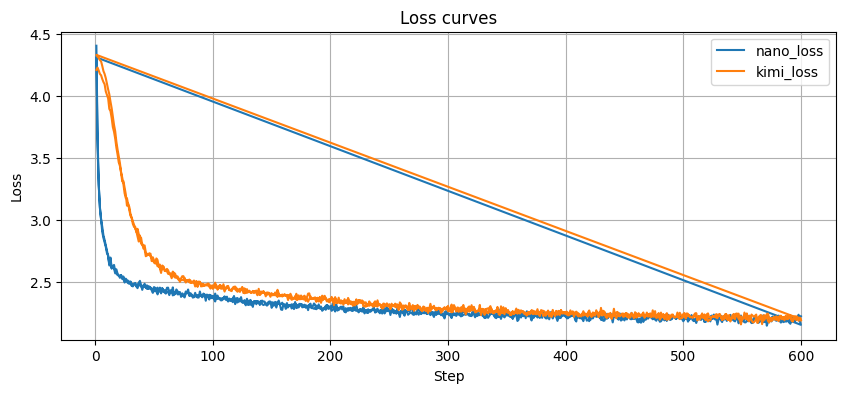

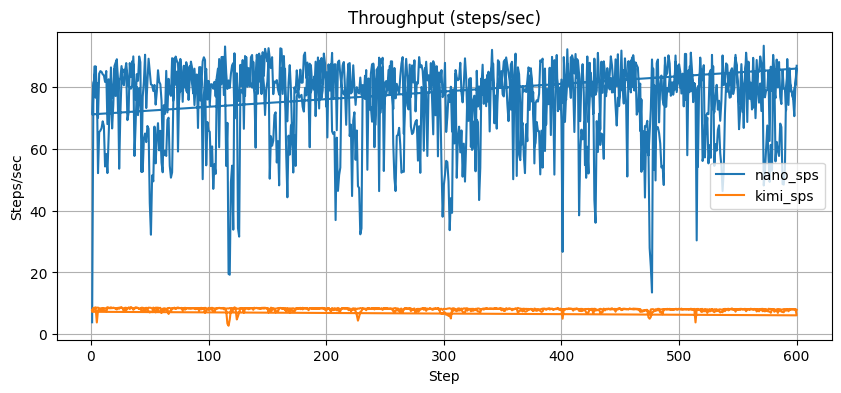

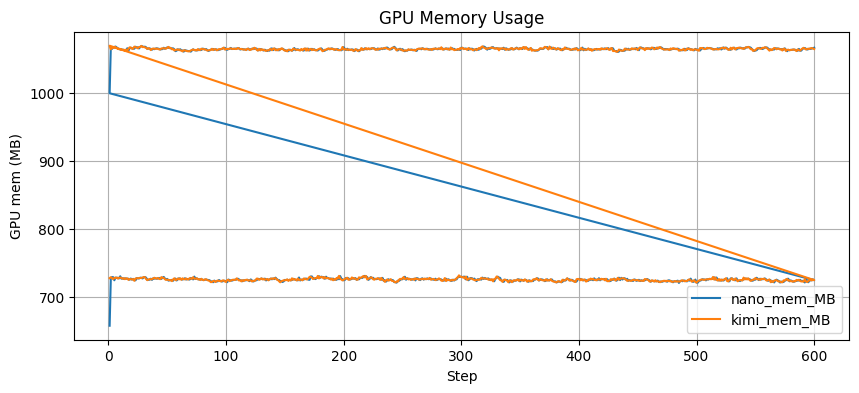

In [32]:
# Cell D - summarize and export
# Build DataFrame where each row is a step (we recorded step per nano append, same index for kimi)
df = pd.DataFrame({
    'step': results['step'],
    'nano_loss': results['nano_loss'],
    'nano_steps_per_sec': results['nano_steps_per_sec'],
    'nano_mem_MB': results['nano_mem_MB'],
    'kimi_loss': results['kimi_loss'],
    'kimi_steps_per_sec': results['kimi_steps_per_sec'],
    'kimi_mem_MB': results['kimi_mem_MB']
})

# overall summary
summary = {
    'model': ['nanoGPT', 'KimiK2'],
    'params': [results['nano_params'], results['kimi_params']],
    'final_loss': [df['nano_loss'].iloc[-1], df['kimi_loss'].iloc[-1]],
    'avg_steps_per_sec': [df['nano_steps_per_sec'].mean(), df['kimi_steps_per_sec'].mean()],
    'max_mem_MB': [max(df['nano_mem_MB']), max(df['kimi_mem_MB'])]
}
summary_df = pd.DataFrame(summary)
print("Summary:\n", summary_df)

# save CSVs
df.to_csv("benchmark_steps.csv", index=False)
summary_df.to_csv("benchmark_summary.csv", index=False)
print("Saved CSVs: benchmark_steps.csv, benchmark_summary.csv")

# plots: loss curves, steps/sec, memory
plt.figure(figsize=(10,4))
plt.plot(df['step'], df['nano_loss'], label='nano_loss')
plt.plot(df['step'], df['kimi_loss'], label='kimi_loss')
plt.xlabel('Step'); plt.ylabel('Loss'); plt.title('Loss curves'); plt.legend(); plt.grid(True)
plt.savefig("loss_curves.png", bbox_inches='tight')

plt.figure(figsize=(10,4))
plt.plot(df['step'], df['nano_steps_per_sec'], label='nano_sps')
plt.plot(df['step'], df['kimi_steps_per_sec'], label='kimi_sps')
plt.xlabel('Step'); plt.ylabel('Steps/sec'); plt.title('Throughput (steps/sec)'); plt.legend(); plt.grid(True)
plt.savefig("steps_per_sec.png", bbox_inches='tight')

plt.figure(figsize=(10,4))
plt.plot(df['step'], df['nano_mem_MB'], label='nano_mem_MB')
plt.plot(df['step'], df['kimi_mem_MB'], label='kimi_mem_MB')
plt.xlabel('Step'); plt.ylabel('GPU mem (MB)'); plt.title('GPU Memory Usage'); plt.legend(); plt.grid(True)
plt.savefig("mem_usage.png", bbox_inches='tight')

# generate PDF report combining summary and images
with PdfPages("benchmark_report.pdf") as pdf:
    # page 1: summary table as text
    fig, ax = plt.subplots(figsize=(8.27, 11.69))  # A4
    ax.axis('off')
    ax.text(0, 0.95, "nanoKimi vs nanoGPT Benchmark Report", fontsize=16, weight='bold')
    ax.text(0, 0.90, f"Date: {time.strftime('%Y-%m-%d %H:%M:%S')}", fontsize=10)
    # add summary table
    table_text = summary_df.to_string(index=False)
    ax.text(0, 0.75, table_text, fontsize=10, family='monospace')
    pdf.savefig(fig, bbox_inches='tight')
    plt.close(fig)
    # page: loss curves
    img = plt.imread("loss_curves.png")
    fig, ax = plt.subplots(figsize=(8.27, 11.69))
    ax.axis('off'); ax.imshow(img); pdf.savefig(fig); plt.close(fig)
    # page: steps/sec
    img = plt.imread("steps_per_sec.png")
    fig, ax = plt.subplots(figsize=(8.27, 11.69)); ax.axis('off'); ax.imshow(img); pdf.savefig(fig); plt.close(fig)
    # page: mem usage
    img = plt.imread("mem_usage.png")
    fig, ax = plt.subplots(figsize=(8.27, 11.69)); ax.axis('off'); ax.imshow(img); pdf.savefig(fig); plt.close(fig)

print("Saved benchmark_report.pdf (includes summary and plots).")


In [33]:
import time, os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Param count helper
def param_count(model):
    return sum(p.numel() for p in model.parameters())

# Safe mkdir for checkpoints
os.makedirs('checkpoints', exist_ok=True)


Using device: cuda


In [34]:
# Hyperparams - adjust for Colab memory
vocab_size = vocab_size  # from your dataset/code
block_size = block_size  # from your dataset/code

model_cfg = dict(vocab_size=vocab_size, dim=384, n_layers=4, n_heads=4, mlp_hidden=1024, block_size=block_size)

# Instantiate nanoGPT and KimiK2
nano = NanoGPT(**model_cfg).to(device)
kimi = KimiK2(vocab_size=vocab_size, dim=384, n_layers=4, n_heads=4, mlp_hidden=1024,
              block_size=block_size, moe_experts=4, moe_k=1, latent_params=dict(latent_dim=128, num_latents=16)).to(device)

# Optimizers (AdamW for nano, Muon or fallback AdamW for kimi)
opt_nano = torch.optim.AdamW(nano.parameters(), lr=3e-4, weight_decay=0.01)
try:
    opt_kimi = Muon(kimi.parameters(), lr=3e-4, weight_decay=0.01, warmup_steps=200, total_steps=5000)
except Exception:
    opt_kimi = torch.optim.AdamW(kimi.parameters(), lr=3e-4, weight_decay=0.01)

print(f"NanoGPT params: {param_count(nano)}")
print(f"KimiK2 params: {param_count(kimi)}")


NanoGPT params: 5622784
KimiK2 params: 15284736


In [35]:
# Use your existing dataloader (should yield (x_batch, y_batch))
it = iter(dataloader)

def get_batch():
    global it
    try:
        xb, yb = next(it)
    except StopIteration:
        it = iter(dataloader)
        xb, yb = next(it)
    return xb.to(device), yb.to(device)


In [36]:
# Use your existing dataloader (should yield (x_batch, y_batch))
it = iter(dataloader)

def get_batch():
    global it
    try:
        xb, yb = next(it)
    except StopIteration:
        it = iter(dataloader)
        xb, yb = next(it)
    return xb.to(device), yb.to(device)


In [37]:
TOTAL_STEPS = 600  # Increase if you want longer training
LOG_INTERVAL = 20
SAVE_INTERVAL = 200

# Store metrics here
metrics = {
    'step': [],
    'nano_loss': [], 'nano_sps': [], 'nano_mem': [],
    'kimi_loss': [], 'kimi_sps': [], 'kimi_mem': []
}

nano.train()
kimi.train()

for step in range(1, TOTAL_STEPS + 1):
    # Train nanoGPT step
    xb, yb = get_batch()
    t0 = time.time()
    logits, loss_nano = nano(xb, yb)
    opt_nano.zero_grad()
    loss_nano.backward()
    torch.nn.utils.clip_grad_norm_(nano.parameters(), 1.0)
    opt_nano.step()
    t1 = time.time()

    nano_sps = 1.0 / (t1 - t0)
    nano_mem = torch.cuda.memory_allocated(device) / 1024 / 1024 if torch.cuda.is_available() else 0

    # Train kimiK2 step
    xb, yb = get_batch()
    t0 = time.time()
    logits_k, loss_kimi = kimi(xb, yb)
    opt_kimi.zero_grad()
    loss_kimi.backward()
    torch.nn.utils.clip_grad_norm_(kimi.parameters(), 1.0)
    opt_kimi.step()
    t1 = time.time()

    kimi_sps = 1.0 / (t1 - t0)
    kimi_mem = torch.cuda.memory_allocated(device) / 1024 / 1024 if torch.cuda.is_available() else 0

    # Log metrics
    metrics['step'].append(step)
    metrics['nano_loss'].append(loss_nano.item())
    metrics['nano_sps'].append(nano_sps)
    metrics['nano_mem'].append(nano_mem)

    metrics['kimi_loss'].append(loss_kimi.item())
    metrics['kimi_sps'].append(kimi_sps)
    metrics['kimi_mem'].append(kimi_mem)

    if step % LOG_INTERVAL == 0:
        print(f"Step {step}: nano_loss={loss_nano.item():.4f} sps={nano_sps:.2f} mem={nano_mem:.1f}MB | "
              f"kimi_loss={loss_kimi.item():.4f} sps={kimi_sps:.2f} mem={kimi_mem:.1f}MB")

    if step % SAVE_INTERVAL == 0 or step == TOTAL_STEPS:
        torch.save(nano.state_dict(), f"checkpoints/nano_step{step}.pth")
        torch.save(kimi.state_dict(), f"checkpoints/kimi_step{step}.pth")


Step 20: nano_loss=2.5768 sps=42.69 mem=1061.7MB | kimi_loss=3.4359 sps=8.30 mem=1058.5MB
Step 40: nano_loss=2.4660 sps=85.35 mem=1059.4MB | kimi_loss=2.7931 sps=8.32 mem=1058.2MB
Step 60: nano_loss=2.3979 sps=52.49 mem=1059.8MB | kimi_loss=2.5617 sps=8.14 mem=1060.0MB
Step 80: nano_loss=2.3845 sps=61.82 mem=1061.6MB | kimi_loss=2.4647 sps=7.79 mem=1062.3MB
Step 100: nano_loss=2.3828 sps=86.25 mem=1059.9MB | kimi_loss=2.4644 sps=8.22 mem=1060.3MB
Step 120: nano_loss=2.3372 sps=84.45 mem=1060.5MB | kimi_loss=2.4349 sps=8.03 mem=1061.0MB
Step 140: nano_loss=2.3250 sps=79.79 mem=1060.4MB | kimi_loss=2.4196 sps=8.25 mem=1060.7MB
Step 160: nano_loss=2.2906 sps=85.66 mem=1063.8MB | kimi_loss=2.4178 sps=8.15 mem=1063.6MB
Step 180: nano_loss=2.2973 sps=88.12 mem=1059.8MB | kimi_loss=2.3591 sps=8.39 mem=1061.6MB
Step 200: nano_loss=2.2773 sps=85.98 mem=1060.8MB | kimi_loss=2.3553 sps=7.82 mem=1060.4MB
Step 220: nano_loss=2.2923 sps=49.05 mem=1059.8MB | kimi_loss=2.3184 sps=8.12 mem=1061.0MB
Ste

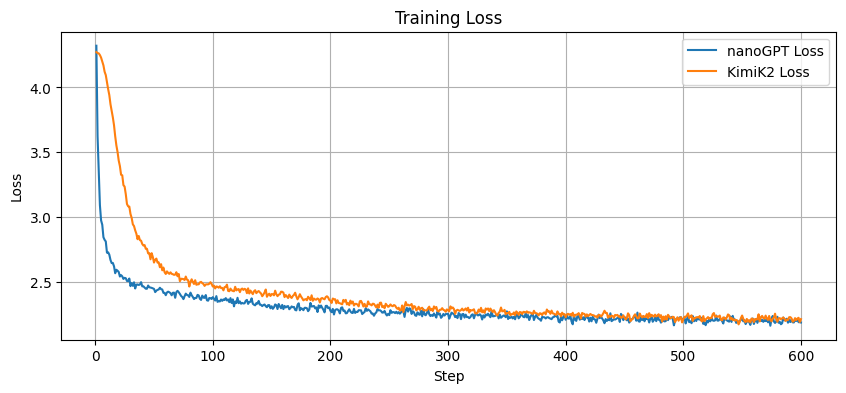

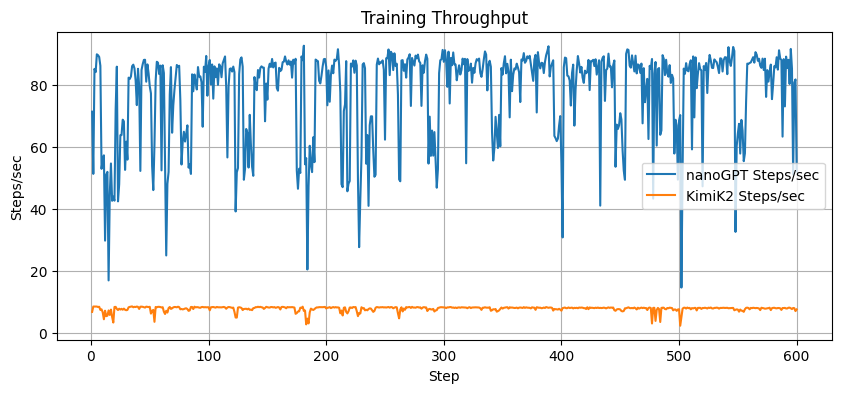

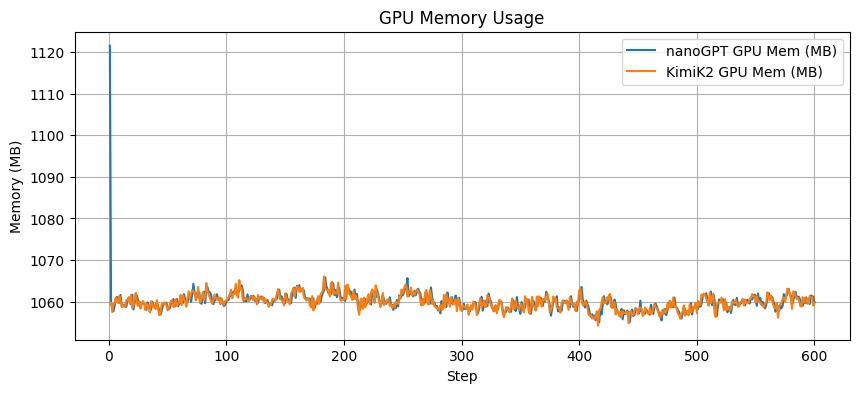

In [38]:
import matplotlib.pyplot as plt

steps = metrics['step']

plt.figure(figsize=(10,4))
plt.plot(steps, metrics['nano_loss'], label='nanoGPT Loss')
plt.plot(steps, metrics['kimi_loss'], label='KimiK2 Loss')
plt.xlabel('Step'); plt.ylabel('Loss'); plt.title('Training Loss'); plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(steps, metrics['nano_sps'], label='nanoGPT Steps/sec')
plt.plot(steps, metrics['kimi_sps'], label='KimiK2 Steps/sec')
plt.xlabel('Step'); plt.ylabel('Steps/sec'); plt.title('Training Throughput'); plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(steps, metrics['nano_mem'], label='nanoGPT GPU Mem (MB)')
plt.plot(steps, metrics['kimi_mem'], label='KimiK2 GPU Mem (MB)')
plt.xlabel('Step'); plt.ylabel('Memory (MB)'); plt.title('GPU Memory Usage'); plt.legend(); plt.grid(True)
plt.show()


In [39]:
import pandas as pd

summary = {
    'Model': ['nanoGPT', 'KimiK2'],
    'Parameters': [param_count(nano), param_count(kimi)],
    'Final Loss': [metrics['nano_loss'][-1], metrics['kimi_loss'][-1]],
    'Avg Steps/sec': [np.mean(metrics['nano_sps']), np.mean(metrics['kimi_sps'])],
    'Max GPU Mem (MB)': [max(metrics['nano_mem']), max(metrics['kimi_mem'])]
}

summary_df = pd.DataFrame(summary)
print(summary_df)


     Model  Parameters  Final Loss  Avg Steps/sec  Max GPU Mem (MB)
0  nanoGPT     5622784    2.187061      77.685026       1121.517090
1   KimiK2    15284736    2.213088       7.763546       1066.072266


In [40]:
prompt = "Once upon a time"
context = torch.tensor([encode(prompt)], dtype=torch.long).to(device)

nano.eval()
kimi.eval()

with torch.no_grad():
    nano_out = nano.generate(context, max_new_tokens=100, temperature=1.0, top_k=40)
    kimi_out = kimi.generate(context, max_new_tokens=100, temperature=1.0, top_k=40)

print("\n--- nanoGPT generated text ---\n", decode(nano_out[0].tolist()))
print("\n--- KimiK2 generated text ---\n", decode(kimi_out[0].tolist()))



--- nanoGPT generated text ---
 Once upon a time ino iee onome menend pene
peneme tonenononon nenounonnonononno nonono oonenonone neenoneonon o
nonn

--- KimiK2 generated text ---
 Once upon a timee a amno e is ap ame: is
s mapaspus apa mas a asamaasasosiamucusha masha
pa aseasan apsa auap ntiaia
